In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [3]:
%reload_ext autoreload
%autoreload 2
import methods

# Objectif : ajouter une dépendance temporelle dans la fonction Campbelle

Nous allons simuler des données d'entrées sur une semaine. (On suppose qu'on a des informations à chaque heure).  
Nos données d'entrée ne sont plus des scalaires mais des fonctions.  
On prend en entrée $x=(f_1,...,f_8)$ et on sort pour chaque position $(z_1,z_2)$ un scalaire.
On souhaite ajouter une notion de périodicité dans les données d'entrée. De plus, afin de rester proche des conditions réelles, on ajoute du bruit à chacune des fonctions.  
La fonction ci-dessous utilise de l'aléa pour créer 8 fonctions uniques à chaque appel.

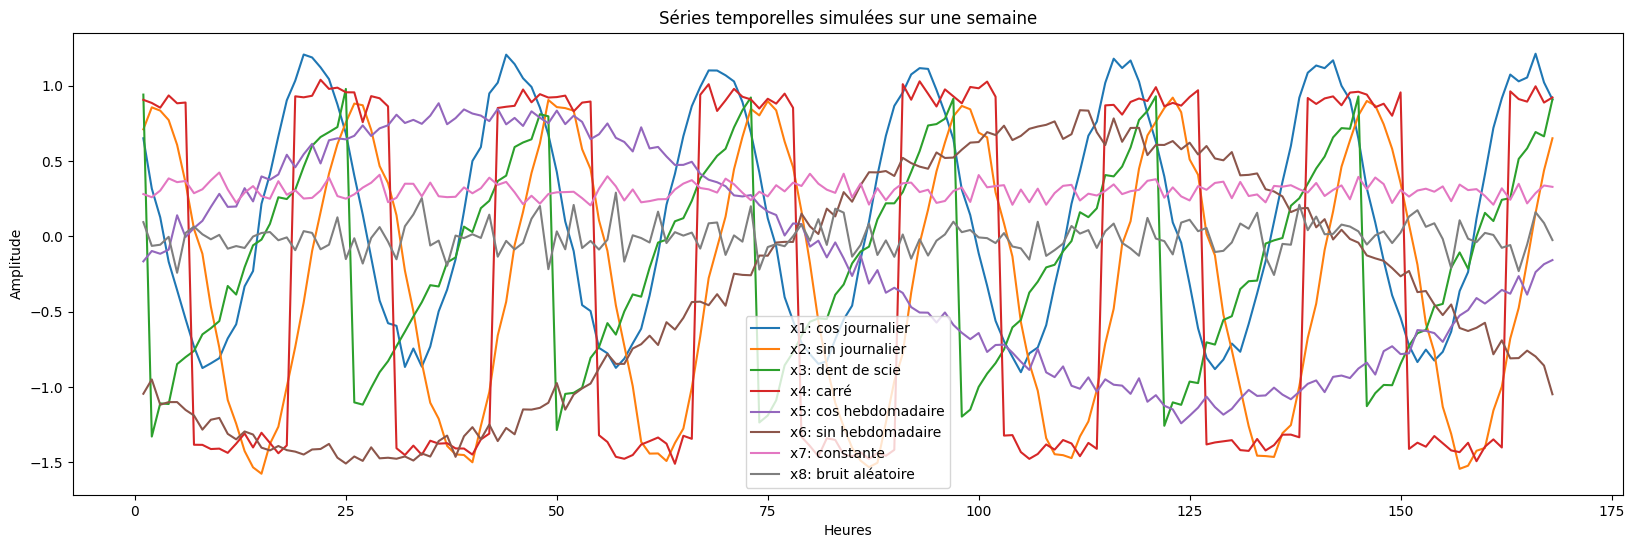

In [ ]:
T=7*24                  #On regarde sur une semaine, avec pour pas de temps une heure.
t=np.linspace(1,T,T)    #t=[1,2,...,168]

def Simulation_semaine_aléatoire():
    # Amplitudes, phases et décalages aléatoires pour chaque signal
    a = np.random.uniform(0.8, 1.2, 6)
    p = np.random.uniform(0, 2*np.pi, 6)
    d = np.random.uniform(-0.5, 0.5, 6)  
    
    # amplitude du bruit que l'on applique aux signaux
    eps = 0.05               
    
    # Génération des signaux
    def x1_func(t): return a[0] * np.cos(2*np.pi*t/24 + p[0])          + d[0] + eps*np.random.randn(T)
    def x2_func(t): return a[1] * np.sin(2*np.pi*t/24 + p[1])          + d[1] + eps*np.random.randn(T)
    def x3_func(t): return a[2] * signal.sawtooth(2*np.pi*t/24 + p[2]) + d[2] + eps*np.random.randn(T)
    def x4_func(t): return a[3] * signal.square(2*np.pi*t/24 + p[3])   + d[3] + eps*np.random.randn(T)
    def x5_func(t): return a[4] * np.cos(2*np.pi*t/(24*7) + p[4])      + d[4] + eps*np.random.randn(T)
    def x6_func(t): return a[5] * np.sin(2*np.pi*t/(24*7) + p[5])      + d[5] + eps*np.random.randn(T)
    def x7_func(t): return np.ones_like(t) * np.random.uniform(0.3, 0.7)      + eps*np.random.randn(T)
    def x8_func(t): return 0.1*np.random.randn(len(t))
    
    return x1_func, x2_func, x3_func, x4_func, x5_func, x6_func, x7_func, x8_func

X = Simulation_semaine_aléatoire()

# Plot
plt.figure(figsize=(20,6))
plt.plot(t, X[0](t), label='x1: cos journalier')
plt.plot(t, X[1](t), label='x2: sin journalier')
plt.plot(t, X[2](t), label='x3: dent de scie')
plt.plot(t, X[3](t), label='x4: carré')
plt.plot(t, X[4](t), label='x5: cos hebdomadaire')
plt.plot(t, X[5](t), label='x6: sin hebdomadaire')
plt.plot(t, X[6](t), label='x7: constante')
plt.plot(t, X[7](t), label='x8: bruit aléatoire')
plt.xlabel('Heures')
plt.ylabel('Amplitude')
plt.title('Séries temporelles simulées sur une semaine')
plt.legend()
plt.show()

On doit mainenant adapter la fonction Campbell2D pour qu'elle prenne en entrée $x=(f_1,...,f_8)$ et la position $(z1,z2)$ et en sortie on récupère simplement un scalaire.
Pour cela nous avons demander à ChatGPT d'imaginer une fonction test du même style que Campbell.

In [ ]:
def Simulateur_de_sortie(x, z1, z2):
    x1=x[0](t)
    x2=x[1](t)
    x3=x[2](t)
    x4=x[3](t)
    x5=x[4](t)
    x6=x[5](t)
    x7=x[6](t)
    x8=x[7](t)
    xi = np.array([x1, x2, x3, x4, x5, x6, x7, x8]).T  # Shape (T, 8)
    # Normalisation de z1/z2 pour éviter explosion
    z1_scaled = z1 / 50   # diviser par 50 → [-1.8, 1.8]
    z2_scaled = z2 / 50

    # Statistiques sur le temps
    x_mean = np.mean(xi, axis=0)
    x_max = np.max(xi, axis=0)
    x_min = np.min(xi, axis=0)
    x_var = np.var(xi, axis=0)

    # Combinaison non-linéaire stable
    val = (
        x_mean[0] * np.exp(-(0.8*z1_scaled + 0.2*z2_scaled - 0.5*x_max[1])**2 / (0.6*x_var[0]+1e-6)) +
        (x_min[1] + x_mean[3]) * np.exp((0.5*z1_scaled + 0.5*z2_scaled) * np.sin(x_mean[0])) +
        x_max[4]*(x_mean[2]-0.5) * np.exp(-(0.4*z1_scaled + 0.6*z2_scaled - x_mean[5])**2 / (0.4*x_var[4]+1e-6)) +
        (x_mean[5] + x_max[7]) * np.exp((0.3*z1_scaled + 0.7*z2_scaled) * np.cos(x_mean[6])) +
        np.sum(np.tanh(x_mean)) * np.exp(-0.5*(z1_scaled**2 + z2_scaled**2))
    )

    return np.abs(val)


On discrétise l'espace comme fait dans le cas précedent.

In [25]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

On obitent le résultat suivant lorsque l'on passe en entrée du simulateur les données du début du notebook.

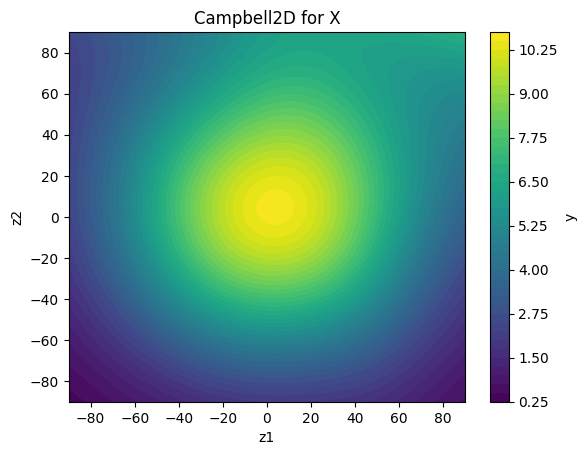

In [ ]:
X=Simulation_semaine_aléatoire  # Les 8 séries temporelles sur la semaine
Y=Simulateur_de_sortie(X,Z1,Z2)         # La carte de sortie


contour = plt.contourf(Z1, Z2, Y, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell2D for X')
plt.show()

## Simulation des données de test et d'entrainement

On doit maintenant simuler tout un ensemble de séries temporelles, qui constituent notre jeu de données de test et d'entrainement. Pour ce faire on va ajouter des paramètres à nos séries temporelles $x_i$ et on va les choisir aléatoirement pour chaque tirage.

In [ ]:
def Entrée_Aléatoire():
    # Amplitudes, phases et offsets aléatoires
    a = np.random.uniform(0.8, 1.2, 6)
    p = np.random.uniform(0, 2*np.pi, 6)
    d = np.random.uniform(-0.5, 0.5, 6)  # décalages verticaux pour cos/sin/saw/square/hebdo
    
    eps = 0.05               # amplitude du bruit
    
    # Génération des signaux
    def x1_func(t): return a[0] * np.cos(2*np.pi*t/24 + p[0])          + d[0] + eps*np.random.randn(T)
    def x2_func(t): return a[1] * np.sin(2*np.pi*t/24 + p[1])          + d[1] + eps*np.random.randn(T)
    def x3_func(t): return a[2] * signal.sawtooth(2*np.pi*t/24 + p[2]) + d[2] + eps*np.random.randn(T)
    def x4_func(t): return a[3] * signal.square(2*np.pi*t/24 + p[3])   + d[3] + eps*np.random.randn(T)
    def x5_func(t): return a[4] * np.cos(2*np.pi*t/(24*7) + p[4])      + d[4] + eps*np.random.randn(T)
    def x6_func(t): return a[5] * np.sin(2*np.pi*t/(24*7) + p[5])      + d[5] + eps*np.random.randn(T)
    def x7_func(t): return np.ones_like(t) * np.random.uniform(0.3, 0.7)
    def x8_func(t): return 0.1*np.random.randn(len(t))
    
    return x1_func, x2_func, x3_func, x4_func, x5_func, x6_func, x7_func, x8_func
    

In [10]:
n_features = 8   # x1..x8
n_test = 1000
n_train = 200

x_test = np.zeros((n_test,n_features, T))  # shape = (1000,8,168)
y_test = np.zeros((n_test,n_grid*n_grid))   # shape = (1000, 4096)

x_train = np.zeros((n_train,n_features, T))  # shape = (200,8,168)
y_train = np.zeros((n_train,n_grid*n_grid))   # shape = (200, 4096)

#On simule les x
for i in range(n_test):
    x_test[i, :, :] = Entrée_Aléatoire()

for i in range(n_train):
    x_train[i, :, :] = Entrée_Aléatoire()

#On calcul les y avec le Simulateur
for i in range(n_train):
    ytrain_i = Simulateur(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()

for i in range(n_test):
    ytest_i = Simulateur(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()

#### Voici les résultats que nous obtenons pour différentes entrées obtenus de manière aléatoire :

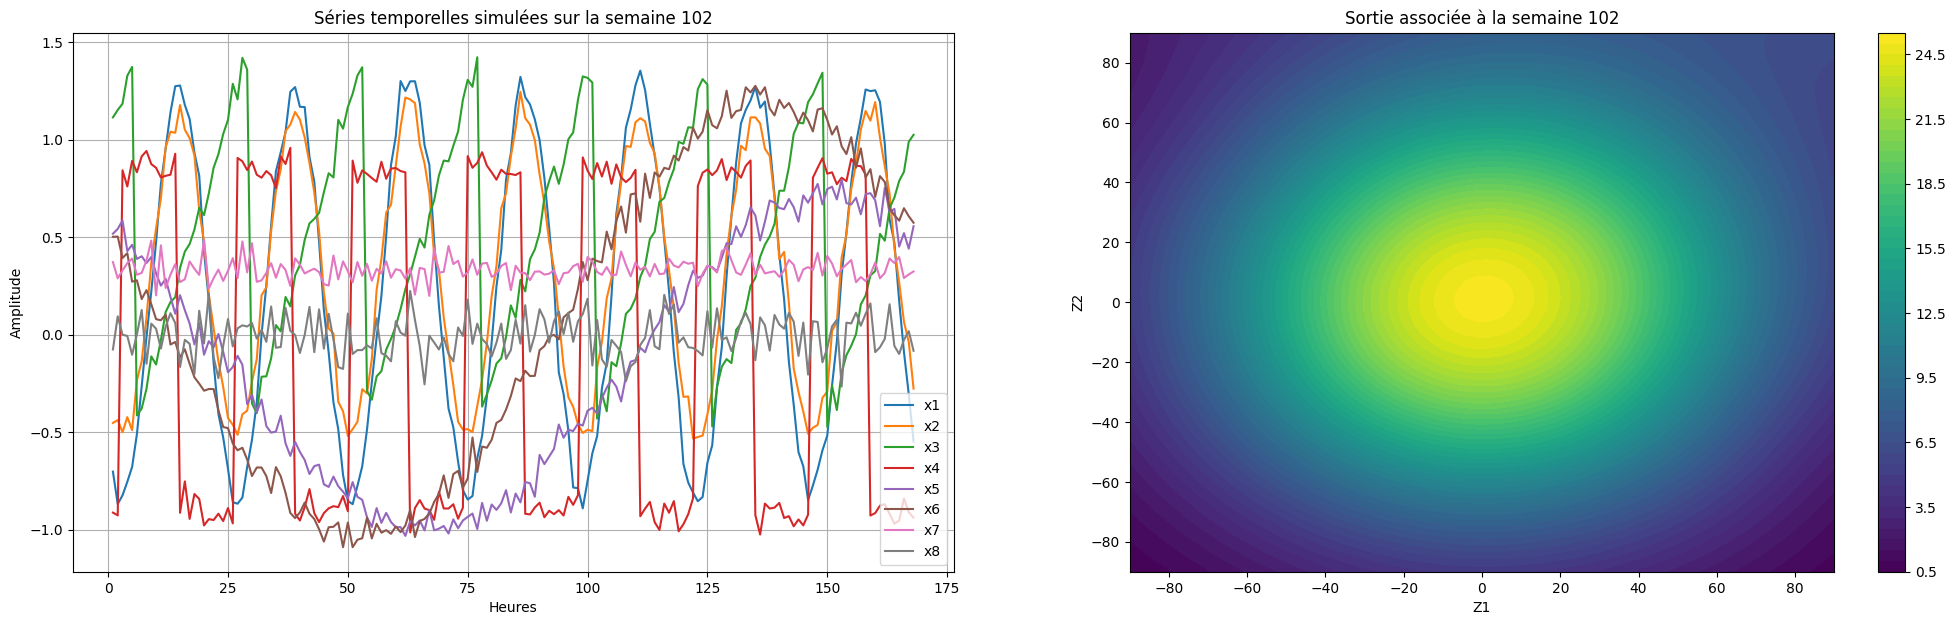

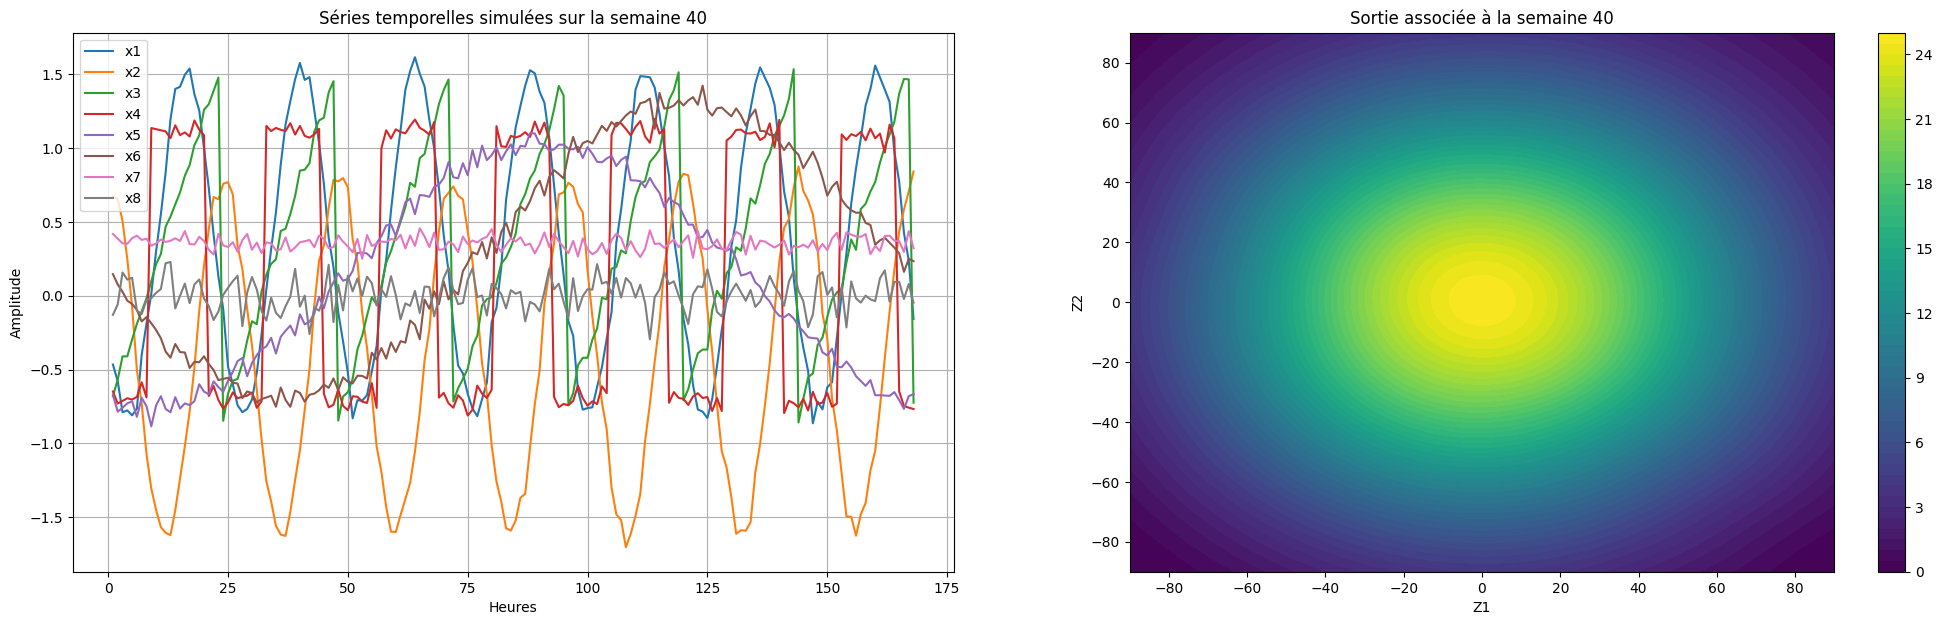

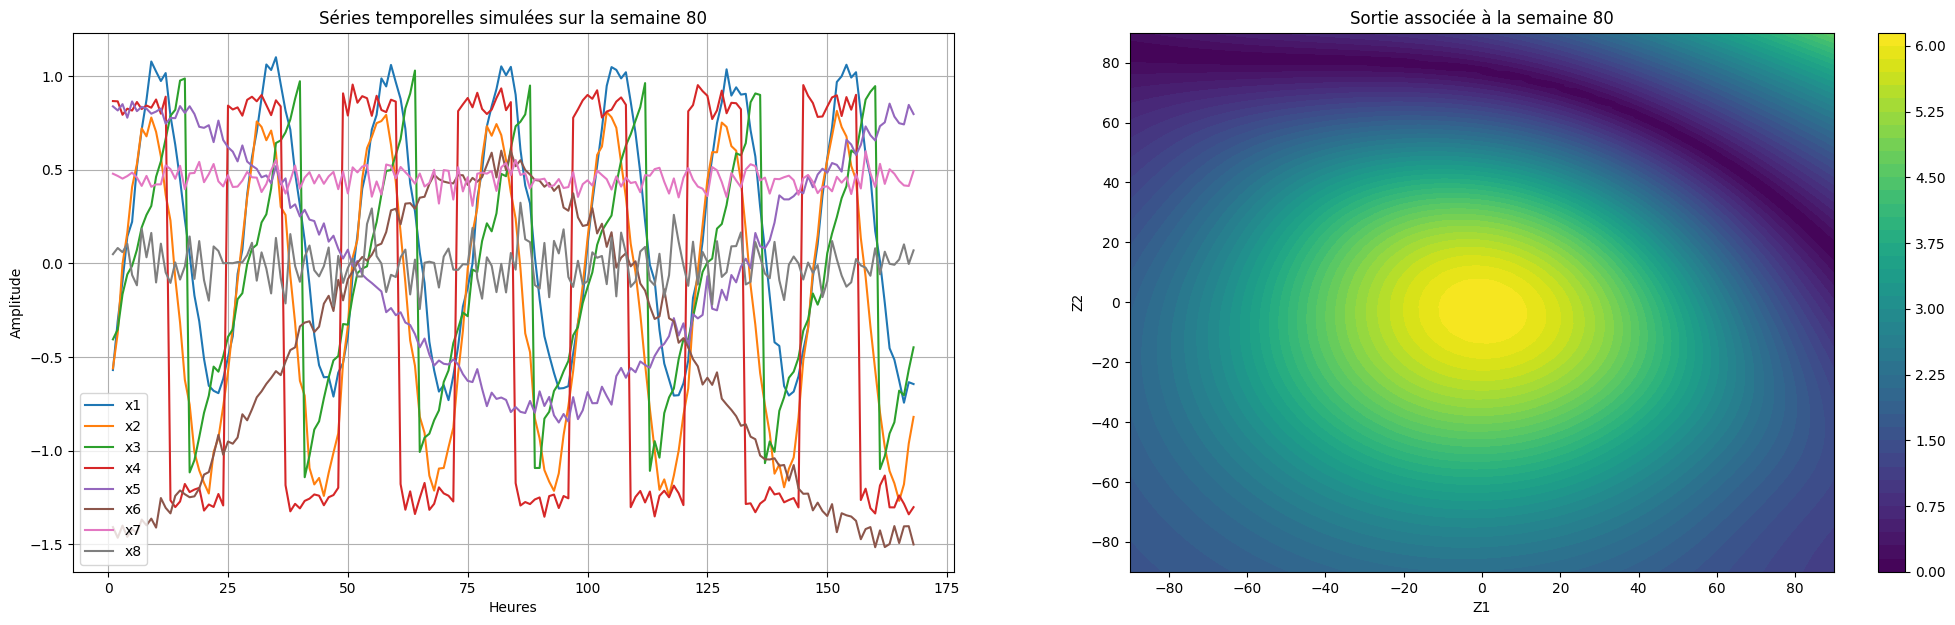

In [11]:
indices = [102,40,80] #à choisir dans [0,199]
for indice in indices:
    fig, axs = plt.subplots(1, 2, figsize=(25, 7))
    for i in range(8):
        axs[0].plot(t, x_test[indice, i], label=f'x{i+1}')
        axs[0].set_xlabel('Heures')
        axs[0].set_ylabel('Amplitude')
        axs[0].set_title(f'Séries temporelles simulées sur la semaine {indice}')
        axs[0].legend()
        axs[0].grid(True)

    # --- Contour ---
    contour = axs[1].contourf(Z1, Z2, np.reshape(y_test[indice, :], (n_grid, n_grid)), levels=50, cmap='viridis')
    fig.colorbar(contour, ax=axs[1])
    axs[1].set_title(f"Sortie associée à la semaine {indice}")
    axs[1].set_xlabel("Z1")
    axs[1].set_ylabel("Z2")

plt.show()

On peut maintenant suivre exactement la même méthode que précedement.

In [12]:
n_pc = 5

X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat  = x_test.reshape(x_test.shape[0], -1)
# APC Classique
theta = 3
sigma = 1
Y_test_reconstruct_ACP = methods.ACP(X_train_flat,X_test_flat,y_train,n_pc,[theta,sigma]) 

# B-spline
t1 = np.concatenate((
    np.repeat(-90, 2),
    np.arange(-80, 91, 10),
    np.repeat( 90, 2)
))
print("vecteur de noeuds",t1)
Y_test_reconstruct_Bsplines = methods.Bsplines_ACP(X_train_flat, X_test_flat, y_train,t1, t1, n_pc, [theta,sigma], degree=1)

# Ondelettes 
K_tilde = 1200
#Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant
p = 0.99999
Y_test_reconstruct_wavelet = methods.ACPF_Ondelettes(X_train_flat,X_test_flat,y_train,n_pc,[theta,sigma],K_tilde=0,p=p,J=2)

(200, 5)
Variance expliquée par les 5 premières composantes : [9.66931318e-01 2.34936171e-02 6.07938669e-03 2.01500259e-03
 3.82411773e-04]
Variance globale expliquée : 0.998901736273275
Taille du jeu d'entrainement transformé par ACP : (200, 5)
Affichage des hyperparamètres optimisés

--- Composante principale 1 ---
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [15.63028]            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────

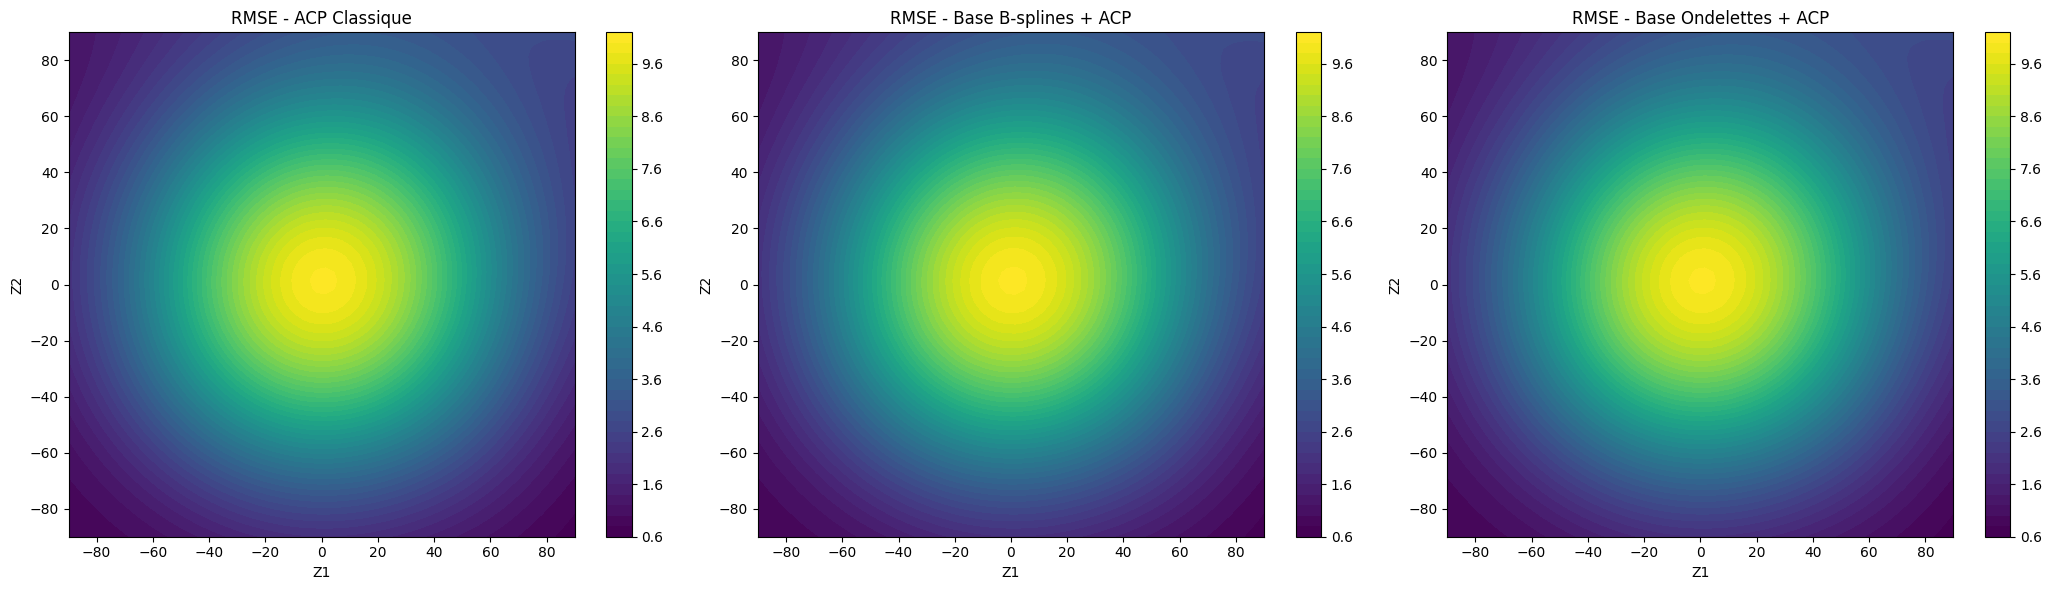

In [13]:
# --- Calcul RMSE pixel-par-pixel (ACP classique)
rmse_ACP = np.sqrt(np.mean((y_test - Y_test_reconstruct_ACP)**2, axis=0))
RMSE_map_ACP = rmse_ACP.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (B-splines)
rmse_BS = np.sqrt(np.mean((y_test - Y_test_reconstruct_Bsplines)**2, axis=0))
RMSE_map_BS = rmse_BS.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (Ondelettes)
rmse_wavelet = np.sqrt(np.mean((y_test - Y_test_reconstruct_wavelet)**2, axis=0))
RMSE_map_wavelet = rmse_wavelet.reshape((n_grid, n_grid))

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(RMSE_map_ACP.min(), RMSE_map_BS.min(), RMSE_map_wavelet.min())
vmax = max(RMSE_map_ACP.max(), RMSE_map_BS.max(), RMSE_map_wavelet.max())

# --- Plot côte à côte
plt.figure(figsize=(21, 6))

# ACP classique
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, RMSE_map_ACP, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, RMSE_map_BS, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, RMSE_map_wavelet, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("RMSE - Base Ondelettes + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()